# Bidirectional LSTM Sentiment Classifier

In this notebook, we use a *bidirectional* LSTM to classify IMDB movie reviews by their sentiment.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/the-deep-learners/deep-learning-illustrated/blob/master/notebooks/bi_lstm_sentiment_classifier.ipynb)

In [ ]:
# scikit-learn for Python3 - Jetson Xavier
# something in the following made it work:

# pip3 install --upgrade setuptools
# sudo pip3 install -U setuptools
# sudo apt-get install libpcap-dev libpq-dev
# sudo pip3 install cython

# finally!:

# sudo pip3 install git+https://github.com/scikit-learn/scikit-learn.git

# Other option
# pip install https://github.com/scikit-learn/scikit-learn/archive/0.20.1.tar.gz
# latest version https://github.com/scikit-learn/scikit-learn/archive/refs/tags/1.2.1.tar.gz


#### Load dependencies

In [1]:
%pip install -r /workspace/requirements_cpu.txt

Note: you may need to restart the kernel to use updated packages.


In [ ]:
# %set_env LD_PRELOAD=/usr/local/lib/python3.8/dist-packages/scikit_learn.libs/libgomp-d22c30c5.so.1.0.0
# %env

In [ ]:
# %set_env LD_PRELOAD=/lib/aarch64-linux-gnu/libgomp.so.1
# %env

In [3]:
#import sklearn
#import keras
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, SpatialDropout1D, LSTM
from tensorflow.keras.layers import Bidirectional # new! 
from tensorflow.keras.callbacks import ModelCheckpoint
import os
from sklearn.metrics import roc_auc_score 
import matplotlib.pyplot as plt 
%matplotlib inline

#### Set hyperparameters

In [3]:
# output directory name:
output_dir = '/workspace/model_output/biLSTM'

# training:
epochs = 6
batch_size = 128

# vector-space embedding: 
n_dim = 64 
n_unique_words = 10000 
max_review_length = 200 # doubled!
pad_type = trunc_type = 'pre'
drop_embed = 0.2 

# LSTM layer architecture:
n_lstm = 256 
drop_lstm = 0.2

#### Load data

In [ ]:
# REF: https://github.com/tensorflow/tensorflow/commit/79a8d5cdad942b9853aa70b59441983b42a8aeb3#diff-b0a029ad68170f59173eb2f6660cd8e0
# apt update && apt install nano -y
# sudo nano /usr/local/lib/python3.8/dist-packages/keras/datasets/imdb.py
# -  with np.load(path) as f:
# +  with np.load(path, allow_pickle=True) as f:

In [4]:
(x_train, y_train), (x_valid, y_valid) = imdb.load_data(num_words=n_unique_words) # removed n_words_to_skip

/usr/local/lib/python3.8/dist-packages/keras/datasets/imdb.py:101: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.8/dist-packages/keras/datasets/imdb.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


#### Preprocess data

In [5]:
x_train = pad_sequences(x_train, maxlen=max_review_length, padding=pad_type, truncating=trunc_type, value=0)
x_valid = pad_sequences(x_valid, maxlen=max_review_length, padding=pad_type, truncating=trunc_type, value=0)

#### Design neural network architecture

In [6]:
model = Sequential()
model.add(Embedding(n_unique_words, n_dim, input_length=max_review_length)) 
model.add(SpatialDropout1D(drop_embed))
model.add(Bidirectional(LSTM(n_lstm, dropout=drop_lstm)))
model.add(Dense(1, activation='sigmoid'))

In [7]:
# LSTM layer parameters double due to both reading directions
model.summary() 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 64)           640000    
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 200, 64)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 512)               657408    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 513       
Total params: 1,297,921
Trainable params: 1,297,921
Non-trainable params: 0
_________________________________________________________________


#### Configure model

In [8]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [9]:
modelcheckpoint = ModelCheckpoint(filepath=output_dir+"/weights.{epoch:02d}.hdf5")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

#### Train!

In [10]:
# - with this toy dataset, the complex interplay of words over long sentence segments, won't be learned much
# - so our CNN picking up location-invariant segments of two to four words that predict review sentiment
# - these are simpler and so easier to learn from the data
# - CNN therefore outperforms on the IMDB data set
model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(x_valid, y_valid), callbacks=[modelcheckpoint])




Train on 25000 samples, validate on 25000 samples
Epoch 1/6




2023-01-26 16:09:28.186088: I tensorflow/core/platform/profile_utils/cpu_utils.cc:109] CPU Frequency: 31250000 Hz
2023-01-26 16:09:28.188063: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x327ecb0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2023-01-26 16:09:28.188219: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2023-01-26 16:09:28.211099: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-01-26 16:09:28.397797: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1049] ARM64 does not support NUMA - returning NUMA node zero
2023-01-26 16:09:28.398439: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x3925250 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-01-26 16:09:28.398532: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor d

2023-01-26 16:09:30.613102: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1206] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-26 16:09:30.613287: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1212]      0 
2023-01-26 16:09:30.613349: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1225] 0:   N 
2023-01-26 16:09:30.614824: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1049] ARM64 does not support NUMA - returning NUMA node zero
2023-01-26 16:09:30.615585: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1049] ARM64 does not support NUMA - returning NUMA node zero
2023-01-26 16:09:30.615995: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1351] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 2485 MB memory) -> physical GPU (device: 0, name: Xavier, pci bus id: 0000:00:00.0, compute capability: 7.2)


2023-01-26 16:09:37.354010: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11


25000/25000 [==============================] - 693s 28ms/step - loss: 0.5798 - acc: 0.6858 - val_loss: 0.3702 - val_acc: 0.8402
Epoch 2/6
25000/25000 [==============================] - 671s 27ms/step - loss: 0.3190 - acc: 0.8691 - val_loss: 0.3220 - val_acc: 0.8682
Epoch 3/6
25000/25000 [==============================] - 667s 27ms/step - loss: 0.2294 - acc: 0.9104 - val_loss: 0.3200 - val_acc: 0.8747
Epoch 4/6
25000/25000 [==============================] - 665s 27ms/step - loss: 0.1832 - acc: 0.9316 - val_loss: 0.3330 - val_acc: 0.8635
Epoch 5/6
25000/25000 [==============================] - 663s 27ms/step - loss: 0.1570 - acc: 0.9438 - val_loss: 0.4223 - val_acc: 0.8396
Epoch 6/6
25000/25000 [==============================] - 666s 27ms/step - loss: 0.1366 - acc: 0.9508 - val_loss: 0.3831 - val_acc: 0.8629


#### Evaluate

In [11]:
model.load_weights(output_dir+"/weights.04.hdf5") 

In [12]:
y_hat = model.predict_proba(x_valid)

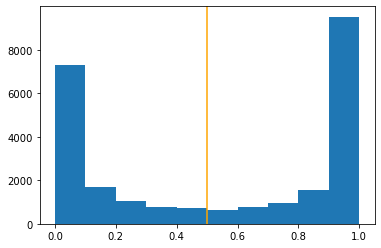

In [13]:
plt.hist(y_hat)
_ = plt.axvline(x=0.5, color='orange')

In [ ]:
"{:0.2f}".format(roc_auc_score(y_valid, y_hat)*100.0)